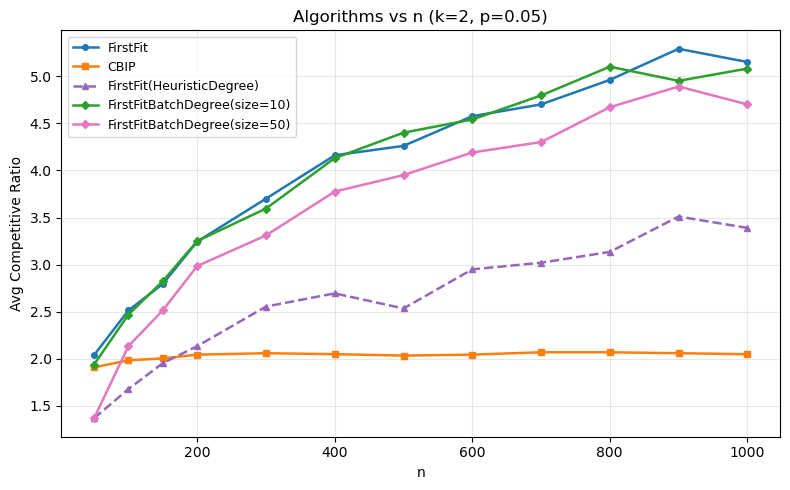

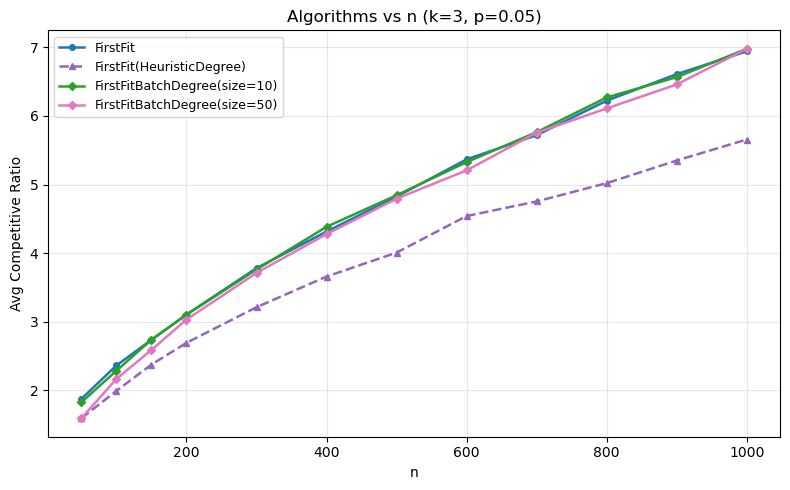

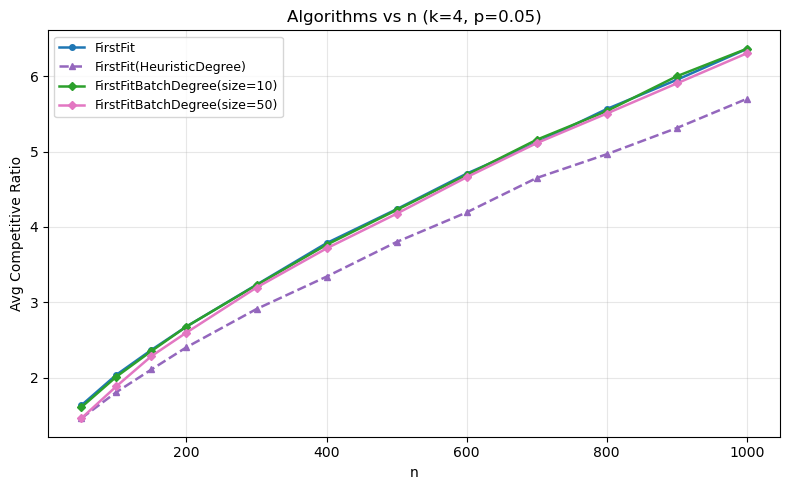

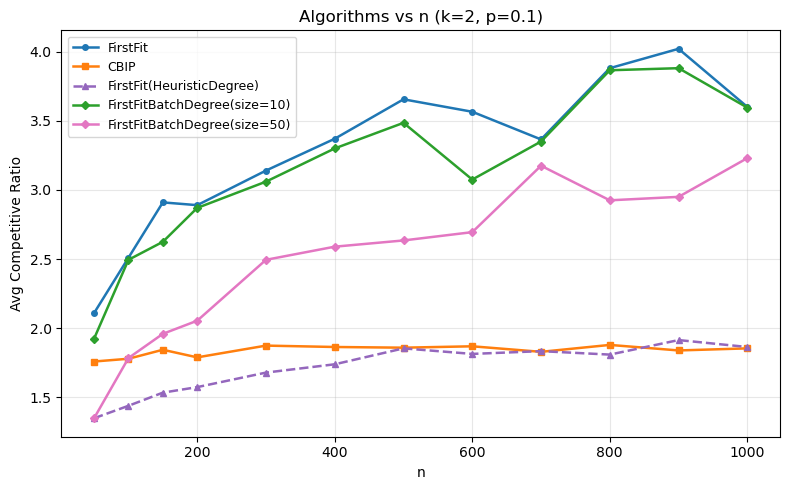

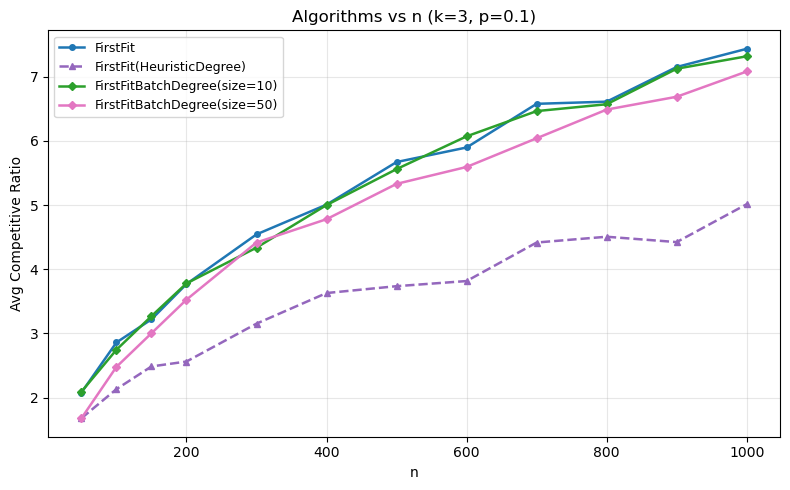

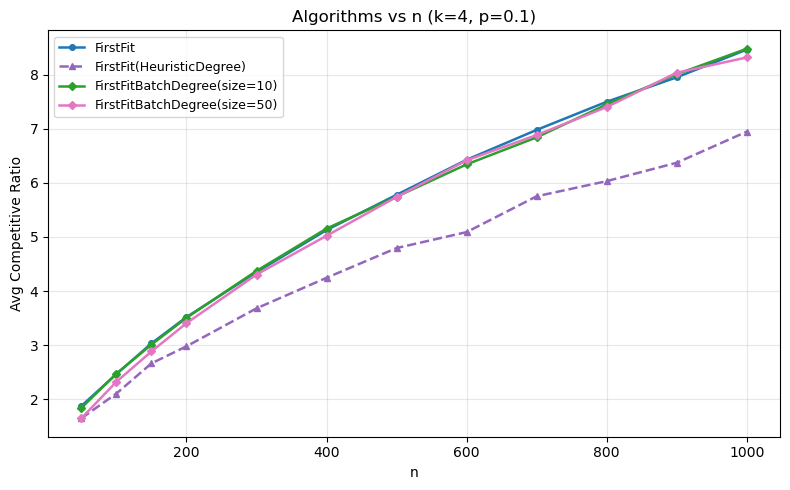

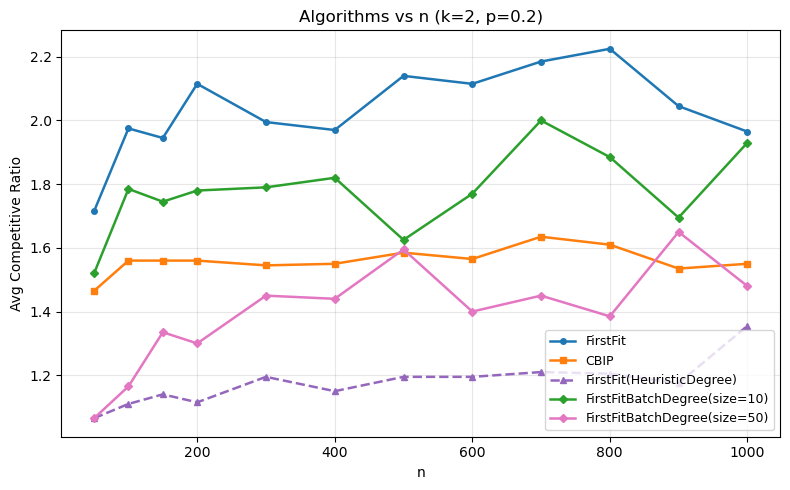

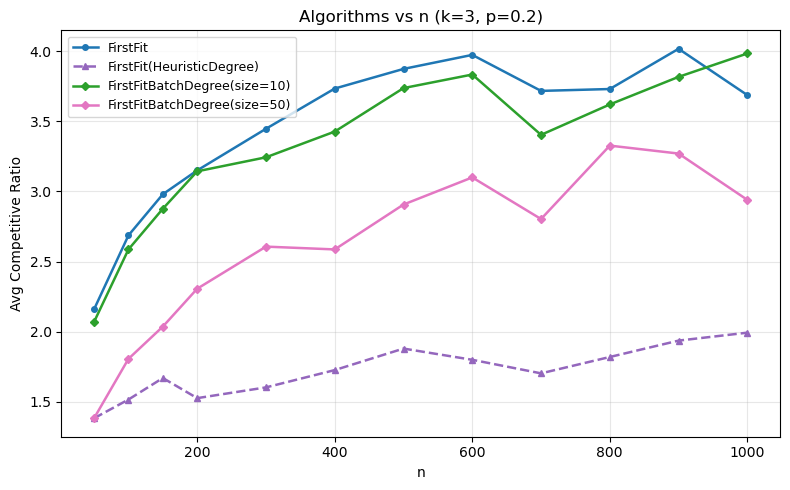

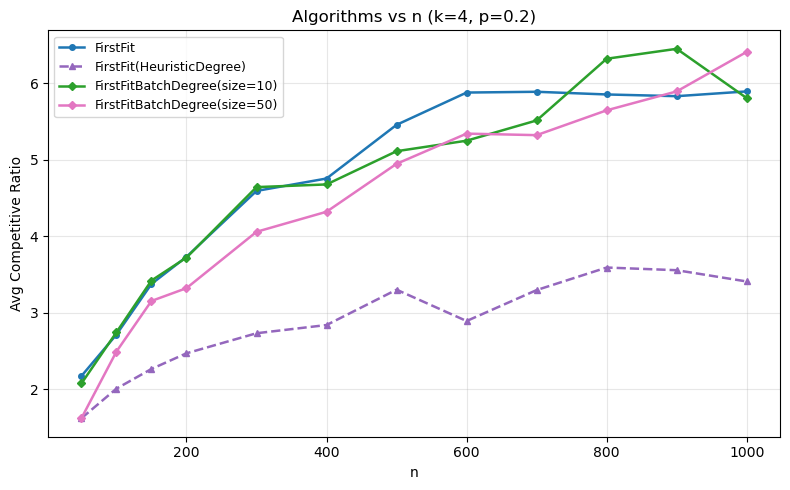

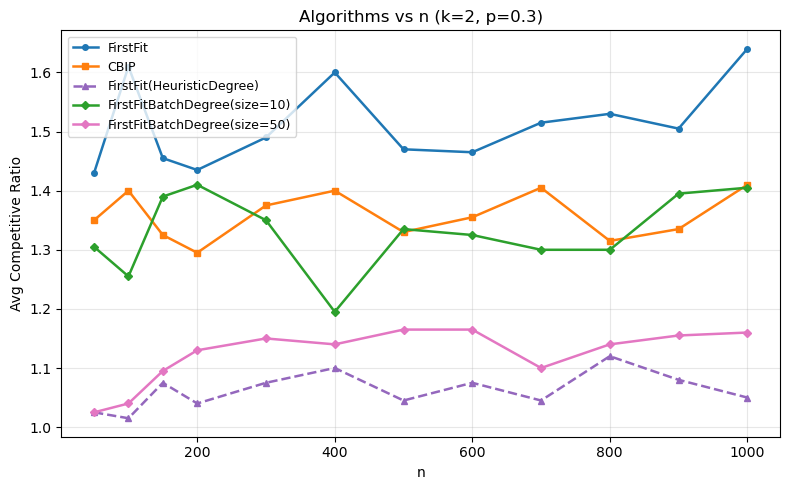

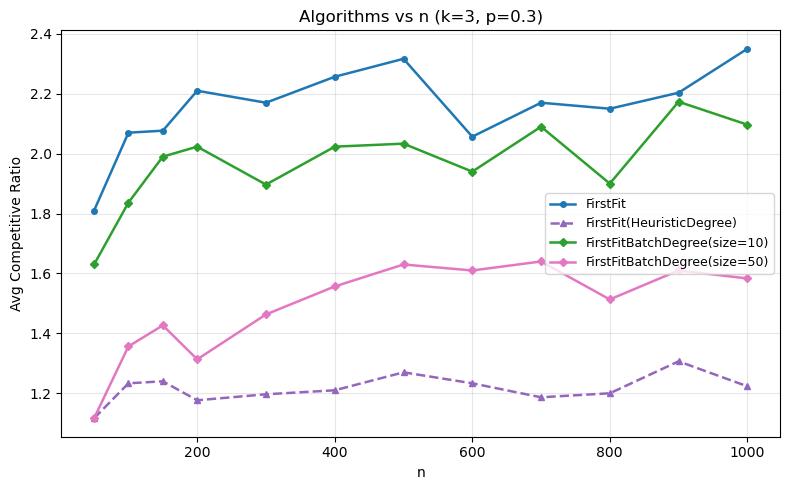

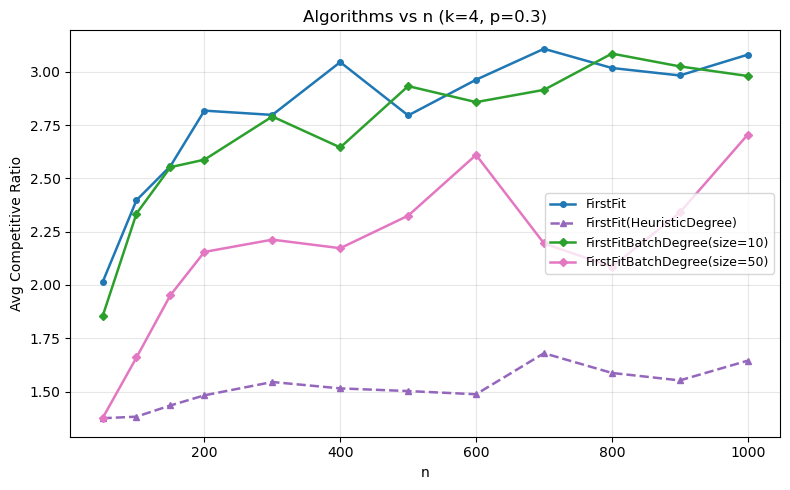

Saved family figures: 12
Wrote enriched CSV: ../outputs/summary_enriched.csv


In [142]:
# Plot results for FirstFit, CBIP, HeuristicDegree, and BatchDegree
import os
import re
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paths (relative to this notebook in project/notebooks)
CSV_PATH = os.path.join('..', 'outputs', 'summary.csv')
OUTPUT_DIR = os.path.join('..', 'outputs')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load results
summary = pd.read_csv(CSV_PATH)
summary['Algorithm'] = summary['Algorithm'].astype(str)

# Parse algorithm base and p value, and extract batch size for BatchDegree
def parse_alg(a: str):
    # Examples: FirstFit[p=0.1], CBIP[p=0.2], FirstFit(HeuristicDegree)[p=0.3], FirstFitBatchDegree(size=10)[p=0.2]
    m = re.match(r'^(.*)\[p=([0-9.]+)\]$', a)
    if not m:
        return a, np.nan, None
    base, p = m.group(1), float(m.group(2))
    size = None
    if base.startswith('FirstFitBatchDegree('):
        m2 = re.search(r'size=([0-9]+)', base)
        if m2:
            size = int(m2.group(1))
    return base, p, size

parsed = summary['Algorithm'].apply(parse_alg)
summary['Base'] = parsed.apply(lambda t: t[0])
summary['pVal'] = parsed.apply(lambda t: t[1])
summary['BatchSize'] = parsed.apply(lambda t: t[2])

# Write an enriched CSV for LaTeX tables
enriched_cols = ['Base','k','n','N','pVal','AvgCompetitiveRatio','StdDev','BatchSize']
summary_enriched = summary[enriched_cols].copy()
summary_enriched.to_csv(os.path.join(OUTPUT_DIR, 'summary_enriched.csv'), index=False)

# Keep only supported algorithms
ALLOWED_PREFIXES = {
    'FirstFit',
    'CBIP',
    'FirstFit(HeuristicDegree)',
}

def is_allowed(base: str):
    return base in ALLOWED_PREFIXES or base.startswith('FirstFitBatchDegree(')

df = summary[summary['Base'].apply(is_allowed)].copy()
df.sort_values(['pVal', 'k', 'n', 'Base', 'BatchSize'], inplace=True)

# Style map
STYLE_MAP = {
    'FirstFit': dict(color='#1f77b4', marker='o', linestyle='-', linewidth=1.8, markersize=4, zorder=3),
    'CBIP': dict(color='#ff7f0e', marker='s', linestyle='-', linewidth=1.8, markersize=4, zorder=3),
    'FirstFit(HeuristicDegree)': dict(color='#9467bd', marker='^', linestyle='--', linewidth=1.8, markersize=4, zorder=3),
}

def style_for(base: str, size: int | None):
    if base.startswith('FirstFitBatchDegree('):
        # Color by size with a simple palette
        palette = ['#2ca02c', '#d62728', '#17becf', '#8c564b', '#e377c2']
        idx = 0 if size is None else (size // 10 - 1) % len(palette)
        return dict(color=palette[idx], marker='D', linestyle='-', linewidth=1.8, markersize=4, zorder=4)
    return STYLE_MAP.get(base, dict(color='gray', marker='x', linestyle='--', linewidth=1.5, markersize=3, zorder=2))

# Family plots: AvgCompetitiveRatio vs n for each (k, p)
save_figure = True
compare_saved = []
for p in sorted(df['pVal'].dropna().unique()):
    for k in (2, 3, 4):
        sub = df[(df['pVal'] == p) & (df['k'] == k)]
        if sub.empty:
            continue
        # Ensure FirstFit baseline exists; skip if missing
        if sub[sub['Base'] == 'FirstFit'].empty:
            continue
        plt.figure(figsize=(8,5))
        present_labels = []
        for base in ['FirstFit', 'CBIP', 'FirstFit(HeuristicDegree)']:
            grp = sub[sub['Base'] == base]
            if grp.empty:
                continue
            grp = grp.sort_values('n')
            st = style_for(base, None)
            plt.plot(grp['n'], grp['AvgCompetitiveRatio'], label=base, **st)
            present_labels.append(base)
        # BatchDegree variants
        batch = sub[sub['Base'].str.startswith('FirstFitBatchDegree(')]
        for size, grp in batch.groupby('BatchSize'):
            grp = grp.sort_values('n')
            label = f'FirstFitBatchDegree(size={int(size)})' if pd.notna(size) else 'FirstFitBatchDegree'
            st = style_for('FirstFitBatchDegree(', int(size) if pd.notna(size) else None)
            plt.plot(grp['n'], grp['AvgCompetitiveRatio'], label=label, **st)
            present_labels.append(label)

        plt.xlabel('n')
        plt.ylabel('Avg Competitive Ratio')
        plt.title(f'Algorithms vs n (k={k}, p={p})')
        plt.grid(True, alpha=0.3)
        if present_labels:
            plt.legend(loc='best', fontsize=9)
        fname = os.path.join(OUTPUT_DIR, f'family_k{k}_p{p}.png')
        plt.tight_layout()
        if save_figure:
            plt.savefig(fname, dpi=150)
            compare_saved.append(fname)
        plt.show()

print('Saved family figures:', len(compare_saved))
print('Wrote enriched CSV:', os.path.join(OUTPUT_DIR, 'summary_enriched.csv'))

In [149]:
# Fitting FirstFit and CBIP curves vs n (adds explicit log fit figure for FirstFit k=2 p=0.05)
import pandas as pd, numpy as np, matplotlib.pyplot as plt, os, math

csv_path = os.path.join('..','outputs','summary.csv')
df = pd.read_csv(csv_path)

# Extract base algorithm and p
alg_p = df['Algorithm'].str.extract(r'^(?P<Alg>[^\[]+)(?:\[p=(?P<p>[^\]]+)\])?')
df['Alg'] = alg_p['Alg']
df['p'] = pd.to_numeric(alg_p['p'], errors='coerce')

# Focus on Simulations I: FirstFit and CBIP (CBIB typo -> CBIP)
df_sim1 = df[df['Alg'].isin(['FirstFit', 'CBIP'])].copy()

# Candidate models mapping name -> function to generate y_hat and num params
# Models of the form y = a + b*f(n) or polynomial degree-2

def fit_model(x, y, f):
    X = np.column_stack([np.ones_like(x), f(x)])
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    y_hat = X @ beta
    return beta, y_hat, 2  # a, b

def fit_poly2(x, y):
    X = np.column_stack([np.ones_like(x), x, x**2])
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    y_hat = X @ beta
    return beta, y_hat, 3  # a, b, c

models = {
    'a + b log n': lambda x,y: fit_model(x,y,lambda t: np.log(t)),
    'a + b sqrt n': lambda x,y: fit_model(x,y,lambda t: np.sqrt(t)),
    'poly deg 2': lambda x,y: fit_poly2(x,y),
}

out_dir = os.path.join('..','outputs')
os.makedirs(out_dir, exist_ok=True)

results = []

for alg in ['FirstFit','CBIP']:
    for k in sorted(df_sim1['k'].unique()):
        for p in sorted(df_sim1['p'].dropna().unique()):
            sub = df_sim1[(df_sim1['Alg']==alg) & (df_sim1['k']==k) & (df_sim1['p']==p)]
            if sub.empty:
                continue
            x = sub['n'].to_numpy(dtype=float)
            y = sub['AvgCompetitiveRatio'].to_numpy(dtype=float)
            # Sort by x
            idx = np.argsort(x)
            x, y = x[idx], y[idx]
            best = None
            for name, fn in models.items():
                try:
                    beta, y_hat, k_params = fn(x,y)
                except Exception:
                    continue
                rmse = float(np.sqrt(np.mean((y - y_hat)**2)))
                # AIC for linear regression with Gaussian errors: 2k + n*log(RSS/n)
                rss = float(np.sum((y - y_hat)**2))
                n_obs = len(y)
                aic = 2*k_params + (n_obs * math.log(rss/n_obs)) if rss>0 else 2*k_params
                if (best is None) or (rmse < best['rmse']):
                    best = {
                        'name': name,
                        'beta': beta,
                        'y_hat': y_hat,
                        'rmse': rmse,
                        'aic': aic,
                    }
            if best is None:
                continue
            # Plot data and best fit
            plt.figure(figsize=(6,4))
            plt.plot(x, y, 'o', label='data')
            plt.plot(x, best['y_hat'], '-', label=f"fit: {best['name']}")
            plt.xlabel('n')
            plt.ylabel('AvgCompetitiveRatio')
            plt.title(f'{alg} k={k} p={p} (best: {best["name"]}, RMSE={best["rmse"]:.3f})')
            plt.legend()
            fname = f'fit_{alg}_k{k}_p{p}.png'
            plt.tight_layout()
            plt.savefig(os.path.join(out_dir, fname), dpi=150)
            plt.close()

            # Residuals
            plt.figure(figsize=(6,3.2))
            plt.plot(x, y - best['y_hat'], 'o-')
            plt.axhline(0,color='gray',linewidth=0.8)
            plt.xlabel('n')
            plt.ylabel('Residual')
            plt.title(f'Residuals {alg} k={k} p={p}')
            rname = f'resid_{alg}_k{k}_p{p}.png'
            plt.tight_layout()
            plt.savefig(os.path.join(out_dir, rname), dpi=150)
            plt.close()

            # Additional explicit log fit figure for FirstFit k=2 p=0.05 (comparison)
            if alg=='FirstFit' and k==2 and abs(p - 0.05) < 1e-9:
                try:
                    log_beta, log_yhat, _ = models['a + b log n'](x, y)
                    plt.figure(figsize=(6,4))
                    plt.plot(x, y, 'o', label='data')
                    plt.plot(x, log_yhat, '-', label='fit: a + b log n')
                    plt.xlabel('n')
                    plt.ylabel('AvgCompetitiveRatio')
                    plt.title(f'{alg} k=2 p=0.05 (log fit comparison)')
                    plt.legend()
                    plt.tight_layout()
                    plt.savefig(os.path.join(out_dir, 'fitlog_FirstFit_k2_p0.05.png'), dpi=150)
                    plt.close()
                except Exception as e:
                    print('Log fit generation failed:', e)

            results.append({
                'Alg': alg, 'k': k, 'p': p, 'best_model': best['name'],
                'rmse': best['rmse'], 'aic': best['aic']
            })

# Save a summary CSV for model selection
fit_summary = pd.DataFrame(results)
fit_summary_path = os.path.join(out_dir, 'fit_summary_sim1.csv')
fit_summary.to_csv(fit_summary_path, index=False)

print(f"Saved fit plots and residuals to: {out_dir}")
print(f"Model selection summary: {fit_summary_path}")
print("Saved explicit log fit figure: fitlog_FirstFit_k2_p0.05.png (comparison)")

Saved fit plots and residuals to: ../outputs
Model selection summary: ../outputs/fit_summary_sim1.csv
Saved explicit log fit figure: fitlog_FirstFit_k2_p0.05.png (comparison)


In [143]:
# Generate multi-p series figures for Simulation I (FirstFit and CBIP)
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
outdir = Path('../outputs')
outdir.mkdir(parents=True, exist_ok=True)

# FirstFit multi-p plots per k
ff = pd.read_csv('../outputs/summary_firstfit.csv')
required_cols = {'k','pVal','n','AvgCompetitiveRatio'}
missing = required_cols - set(ff.columns)
if missing:
    print(f"Missing columns in FirstFit CSV: {missing}")
else:
    for k_val in sorted(ff['k'].unique()):
        sub = ff[ff['k']==k_val].copy()
        plt.figure(figsize=(6.5,4))
        for p in sorted(sub['pVal'].unique()):
            line = sub[sub['pVal']==p].sort_values('n')
            plt.plot(line['n'], line['AvgCompetitiveRatio'], marker='o', label=f"p={p}")
        plt.title(f"FirstFit Competitive Ratio vs n (k={k_val})")
        plt.xlabel('n')
        plt.ylabel('Avg Competitive Ratio')
        plt.grid(alpha=0.3)
        plt.legend(title='Density p', fontsize=8)
        fname = outdir / f"firstfit_k{k_val}_family.png"
        plt.tight_layout()
        plt.savefig(fname, dpi=150)
        plt.close()
        print(f"Saved {fname}")

# CBIP multi-p plot (only k=2 expected)
cbip_path = Path('../outputs/summary_cbip.csv')
if cbip_path.exists():
    cb = pd.read_csv(cbip_path)
    miss_cb = required_cols - set(cb.columns)
    if miss_cb:
        print(f"Missing columns in CBIP CSV: {miss_cb}")
    else:
        cb_k2 = cb[cb['k']==2]
        if cb_k2.empty:
            print('No CBIP data for k=2')
        else:
            plt.figure(figsize=(6.5,4))
            for p in sorted(cb_k2['pVal'].unique()):
                line = cb_k2[cb_k2['pVal']==p].sort_values('n')
                plt.plot(line['n'], line['AvgCompetitiveRatio'], marker='o', label=f"p={p}")
            plt.title('CBIP Competitive Ratio vs n (k=2)')
            plt.xlabel('n')
            plt.ylabel('Avg Competitive Ratio')
            plt.grid(alpha=0.3)
            plt.legend(title='Density p', fontsize=8)
            fname = outdir / 'cbip_k2_family.png'
            plt.tight_layout()
            plt.savefig(fname, dpi=150)
            plt.close()
            print(f"Saved {fname}")
else:
    print('CBIP summary CSV not found.')


Saved ../outputs/firstfit_k2_family.png
Saved ../outputs/firstfit_k3_family.png
Saved ../outputs/firstfit_k4_family.png
Saved ../outputs/cbip_k2_family.png


In [148]:
# Composite 2x2 grid for FirstFit: k=2,3,4 (no delta panel)
import pandas as pd, matplotlib.pyplot as plt, numpy as np
from pathlib import Path
outdir = Path('../outputs')
ff = pd.read_csv('../outputs/summary_firstfit.csv')
req = {'k','pVal','n','AvgCompetitiveRatio'}
if not req.issubset(ff.columns):
    print('Missing columns, cannot build grid.')
else:
    ks = sorted(ff['k'].unique())
    densities = sorted(ff['pVal'].unique())
    # Create a 2x2 grid but only use three panels for k=2,3,4
    fig, axes = plt.subplots(2,2, figsize=(9,7))
    ax_map = {(0,0):ks[0], (0,1):ks[1], (1,0):ks[2]}
    colors = plt.cm.viridis(np.linspace(0,1,len(densities)))
    handles, labels = None, None
    for pos, k_val in ax_map.items():
        ax = axes[pos]
        subset = ff[ff['k']==k_val]
        for c,p in zip(colors,densities):
            line = subset[subset['pVal']==p].sort_values('n')
            h = ax.plot(line['n'], line['AvgCompetitiveRatio'], marker='o', color=c, label=f"p={p}")
        ax.set_title(f"FirstFit k={k_val}")
        ax.set_xlabel('n')
        ax.set_ylabel('Avg CR')
        ax.grid(alpha=.3)
    # Hide the unused bottom-right panel
    axes[1,1].axis('off')
    # Shared legend (densities for visible panels)
    handles, labels = axes[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(densities), title='Density p', frameon=False)
    fig.tight_layout(rect=(0,0.07,1,1))
    out_path = outdir/'firstfit_grid.png'
    fig.savefig(out_path, dpi=160)
    plt.close(fig)
    print(f"Saved {out_path}")

Saved ../outputs/firstfit_grid.png
